# Import

In [1]:
import re
import os
import numpy as np
import pandas as pd
import json
import champ_dataset
import random
import tensorflow as tf
from tensorflow.python.client import device_lib
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

2024-12-08 00:39:39.425593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 00:39:39.442919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 00:39:39.462198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 00:39:39.467993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 00:39:39.482851: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-12-08 00:40:01.569935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-08 00:40:01.571623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-12-08 00:40:01.573032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-12-08 00:40:01.574274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-12-08 00:40:01.575482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1675068941297921057
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23342743552
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 25602875810388316
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabilit

In [4]:
MODEL_NAME = 'distiled_bert'
RUN = 'run10'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/MATH/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN + '/'
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Duong_LLM/Data/MATH/
/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data Champdataset

In [6]:
# =================================Load the dataset==================================
# dataset is a champ_dataset.Dataset instance; 'v0' is the dataset used in the paper
dataset = champ_dataset.load('v0')

# =====================Get a random problem and read its content=====================
# get a random problem; dataset.problems is a dictionary
problem_id = random.choice(list(dataset.problems.keys()))
# shortcut for dataset.problems[problem_id]
problem = dataset[problem_id]
# problem identifier (which is equal to problem_id) and problem statement
print(f'{problem.identifier}: {problem.text}')

P_Number-Theory_18: Find all integer solutions to the equation x^2-3y^2=17.


In [7]:
# iterate over the list of relevant concepts and hints
for ch_id in problem.ch_list:
    ch = dataset[ch_id]  # ch is either a champ_dataset.Concept instance or champ_dataset.Hint instance
    if isinstance(ch, champ_dataset.Concept):  # displaying a concept
        print(f'We have a concept: {ch.identifier}')
        print(f'Text: {ch.text}')  # content of the concept
        print(f'Category: {ch.category}')  # category of the concept
        if ch.name is not None:  # some concept has a name
            print(f'Name: {ch.name}')
        if ch.parent is not None:  # some concept has a parent concept (i.e., a more general version)
            print(f'Parent concept ({ch.parent.identifier}): {ch.parent.text}')
        print('-------------End of this concept-------------')
    else:  # displaying a hint
        print(f'We have a hint: {ch.identifier}')
        print(f'Text: {ch.text}')  # content of the hint
        print('--------------End of this hint---------------')
print('\n')

We have a hint: H_Number-Theory_18_1
Text: Consider the equation modulo 3.
--------------End of this hint---------------
We have a concept: C_nsq_mod3
Text: For integer n, n^2 mod 3 is either 0 or 1.
Category: Number-Theory
-------------End of this concept-------------
We have a concept: C_mod2
Text: (a+b) mod m=((a mod m)+(b mod m) mod m). (a-b) mod m=((a mod m)-(b mod m) mod m). ab mod m=((a mod m)*(b mod m) mod m). a^k mod m=((a mod m)^k mod m).
Category: Number-Theory
Name: modular arithmetic rules
-------------End of this concept-------------




In [8]:
champ_topic_mapping = {
    'Polynomial': 0,
    'Sequence': 1,
    'Number-Theory': 2,
    'Combinatorics': 3,
    'Inequality': 4,
}

list_champ_topic_type = ['Polynomial','Sequence','Number-Theory','Combinatorics','Inequality']

In [9]:
problem_type_list = []
problem_text_list = []

for i in dataset.problems.keys():
    problem = dataset[i]
    current_promt = problem.text
    problem_text_list.append(current_promt)
    for current_type in list_champ_topic_type:
        if current_type in problem.identifier:
            problem_type_list.append(current_type)
            break


print(len(problem_type_list), '  ', len(problem_text_list))

270    270


In [10]:
pd.set_option('display.max_colwidth', None)
df= pd.DataFrame()
df['topic'] = problem_type_list
df['problem'] = problem_text_list
df['topic_encoded'] = df['topic'].map(champ_topic_mapping)
df

,topic,problem,topic_encoded
0,Combinatorics,"Let a string consist of digit 1, 2, 3. How many such strings of length 6 have adjacent digit differing by less than or equal to 1?",3
1,Combinatorics,"How many strings of length 5 using the digits {0, 1, ..., 9} (with leading zeros allowed) have strictly increasing digits?",3
2,Combinatorics,"On a chess board, two rooks are placed peacefully if they are not on the same row or column. For an n x n chess board, find the number of ways that n rooks can be placed peacefully (i.e., any two are placed peacefully) and the placing is also invariant to a 180-degree rotation.",3
3,Combinatorics,"A one-to-one mapping p: {1, 2, ..., n}->{1, 2, ..., n} is called an involution, if p∘p=identity (i.e., p(p(i))=i for all i∈{1, ..., n}). Find the number of involutions on {1, 2, 3, 4, 5, 6}.",3
4,Combinatorics,"How many subsets of {1, 2,..., 10} have no two successive numbers?",3
...,...,...,...
265,Sequence,"In how many ways can 12 geometric progressions be selected from the numbers 1, 2, ..., 100 such that every number is in exactly one progression?",1
266,Sequence,"Let x_1=2, y_1=4, z_1=6/7, and define x_(n+1)=2x_n/(x_n^2-1), y_(n+1)=2y_n/(y_n^2-1), z_(n+1)=2z_n/(z_n^2-1). Is it possible for x_n+y_n+z_n=0 for some n?",1
267,Sequence,"A function f(x) satisfies f(x+1)+f(x-1)=sqrt(2)*f(x). Determine whether the function is periodic, and if so, find its period.",1
268,Sequence,"The sequence {x_n} is defined by x_1=2, x_(n+1)=(2+x_n)/(1−2x_n), and it is known that there are no x_n=0. Could x_p=x_q for any p≠q, and if so, find the smallest possible value of p+q.",1


In [11]:
df.groupby(['topic','topic_encoded']).size()

topic          topic_encoded
Combinatorics  3                40
Inequality     4                50
Number-Theory  2                80
Polynomial     0                50
Sequence       1                50
dtype: int64

In [12]:
df[df['topic']== 'Inequality']

,topic,problem,topic_encoded
40,Inequality,"Let x be a root of the polynomial ax^2+bx+c, with a>0, a+b+c≥0, a-b+c≥0, a-c≥0. What is the range of x, expressed as an interval?",4
41,Inequality,"For positive a, b, what is the smallest value of (a^2+b^2)/(a+b)^2?",4
42,Inequality,"For positive a, b, c, what is the smallest value of (a^3+b^3+c^3)/((a+b+c)(a^2+b^2+c^2))?",4
43,Inequality,What's the smallest value of (x^2+2)/sqrt(x^2+1) for real x?,4
44,Inequality,Find the minimum value of sin(x)^3/cos(x)+cos(x)^3/sin(x) for 0<x<π/2.,4
45,Inequality,Let A=(1/2)*(3/4)*(5/6)*...*(99/100). Is A greater than 0.1?,4
46,Inequality,"If a, b, c are side lengths of a (possibly degenerate) triangle, then what is the largest value of a/(b+c)+b/(a+c)+c/(a+b)?",4
47,Inequality,"For positive numbers x_1, ..., x_n, what is the smallest value of x_1^(n+1)+x_2^(n+1)+...+x_n^(n+1)-x_1*x_2*...*x_n*(x_1+x_2+...+x_n)?",4
48,Inequality,"Let x(n)=2^2^2^...^2 with n 2's, and y(n)=3^3^3^...^3 with n 3's. Among integer values of n≥3, what is the relationship between x(n) and y(n-1): x(n)>y(n-1) for all n≥3, x(n)<y(n-1) for all n≥3, or x(n)>y(n-1) for some n and x(n)<y(n-1) for some other n?",4
49,Inequality,"For x, y, z>0, what is the smallest value of x^2/y^2+y^2/z^2+z^2/x^2-(y/x+z/y+x/z)?",4


# Load model

In [13]:
model_dict = {}
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
model_dict['model_0'] = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model0')
model_dict['model_1'] = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model1')
model_dict['model_0'].summary()


/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-12-08 00:40:02.830795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-08 00:40:02.831267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-12-08 00:40:02.831706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:202

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_dict['model_0'].config

DistilBertConfig {
  "_name_or_path": "/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model0",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

# Predicting

In [15]:
#function remove all formating character from text
def remove_formatting(text):
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    # Remove curly braces
    text = re.sub(r'{|}', '', text)
    # Remove Markdown formatting (e.g., **bold**, *italic*, `code`)
    text = re.sub(r'\*\*|\*|`', '', text)
    # Remove Markdown headers (e.g., # Header)
    text = re.sub(r'#', '', text)
    # Remove escape characters
    text = re.sub(r'\\', '', text)
    # remove special character
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\$', '', text)
    # Remove everything after '(A)'
    text = re.sub(r'\(A\).*', '', text)
    text = re.sub(r'\(a\).*', '', text)
    # Remove everything after "b'"
    text = re.sub(r'b\'', '', text)
    return text

In [16]:
def tokenizing_data(data, tokenizer):
    '''
    description:
        The function will take list of data and tokenize it.
    required:
        remove_formatting() function
    input:
        data: list of text.
        tokenizer: tokenizer from DistilBertTokenizer
    output:
        data_encoded: tokenized_data in tf.tensor
    '''
    data_cleared = pd.Series(data).apply(remove_formatting)
    data_encoded = tokenizer(list(data_cleared), truncation=True, padding=True,return_tensors="tf")

    return data_encoded    

In [17]:
def model_predict(data, model):
    '''
    description:
        function will take tokenized data and predict it
    input:
        data: tokenized_data using DistilBertTokenizer, and in tf.tensor type.
        model: model from TFDistilBertForSequenceClassification
    output:
        output: output of model
    '''
    output = model(data)[0]
    return output
    

## Champ math problem

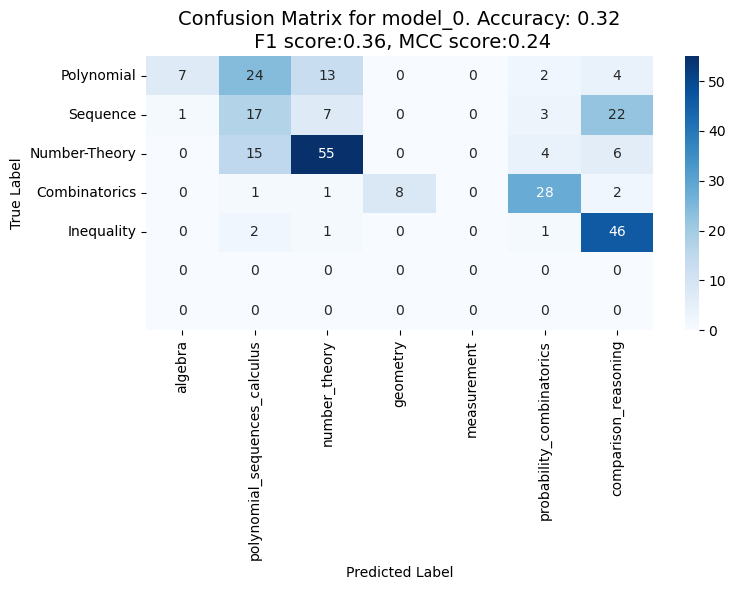

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_0'

data_tokenized = tokenizing_data(df['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df['topic_encoded'])


# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_champ_"+ current_model + ".png")
plt.show()

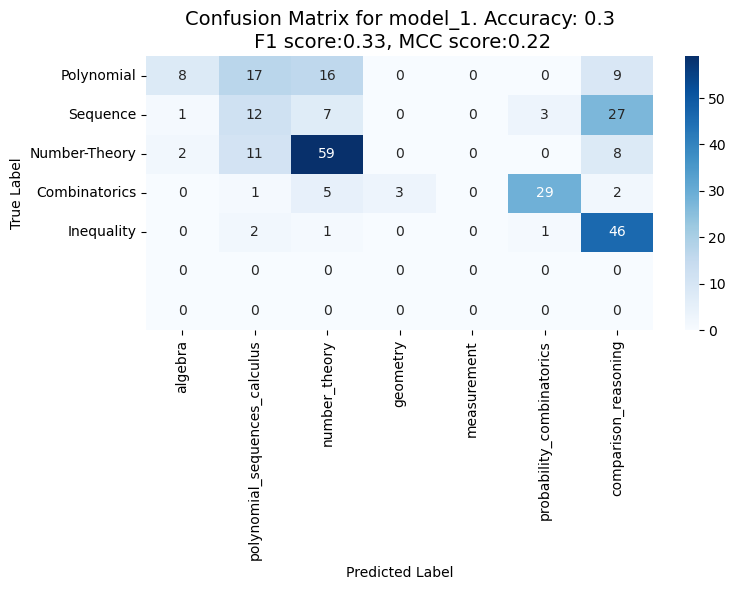

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_1'

data_tokenized = tokenizing_data(df['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df['topic_encoded'])


# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_champ_"+ current_model + ".png")
plt.show()

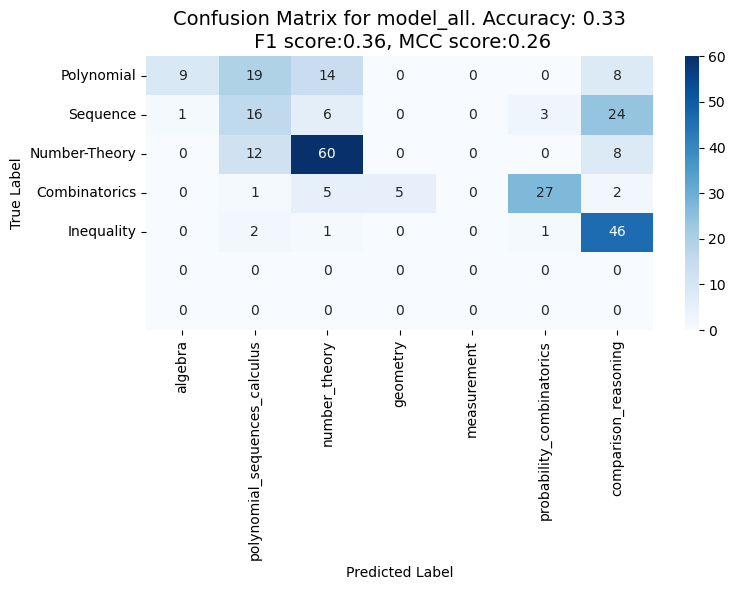

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_all'

data_tokenized = tokenizing_data(df['problem'],tokenizer)   #tokenizing
output_0 = model_predict(data_tokenized,model_dict['model_0'])         #predicting
output_1 = model_predict(data_tokenized,model_dict['model_1'])         #predicting
y_pred = np.argmax(output_0 + output_1,axis=1)
y_test = list(df['topic_encoded'])


# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_champ_"+ current_model + ".png")
plt.show()

## Contept Duong_data

In [21]:
CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/Duong_data/'

In [22]:
topic_mapping = {
    'algebra': 0,
    'polynomial_sequences_calculus': 1,
    'number_theory': 2,
    'geometry': 3,
    'measurement': 4,
    'probability_combinatorics': 5,
    'comparison_reasoning': 6
}


df_concept_duong = pd.read_csv(DATA_DIR + 'testset_duong_data.csv',index_col=0)
df_concept_duong['topic_encoded'] = df_concept_duong['topic'].map(topic_mapping)

df_concept_duong

,search,topic,problem,topic_encoded
1061,probability_combinatorics#Independent Trials,probability_combinatorics,"Independent Trials: Hensel's Lemma: A result in number theory that provides conditions under which a solution to a congruence modulo a prime power can be ""lifted"" to a solution modulo a higher power of the prime, using p-adic numbers.",5
1062,number_theory#Period Finding,number_theory,Period Finding: Surface Area: The total area of all external faces of a three-dimensional object.,2
1063,"algebra#**Definiteness**: Hermitian matrices can be positive or negative definite/semidefinite, determining various properties in quadratic forms.",algebra,"Definiteness: Hermitian matrices can be positive or negative definite/semidefinite, determining various properties in quadratic forms.: Least Common Multiple (LCM) in Parallel Computing: The smallest multiple shared by two or more numbers, computed efficiently across multiple processors to enhance performance.",0
1064,geometry#Cross Product and Plane Normal,geometry,"Cross Product and Plane Normal: Recursive relationships in probability combinatorics often involve breaking down complex probability problems into simpler, smaller problems. The binomial theorem provides a formula for expanding expressions raised to a power, and Pascal's Triangle is a triangular array of numbers that provides coefficients for the binomial expansion, demonstrating recursive relationships in its construction.",3
1065,geometry#Volume Comparison of Solids,geometry,"Volume Comparison of Solids: Inradius: The inradius of a triangle is the radius of the largest circle that fits inside the triangle, touching all three sides.",3
...,...,...,...,...
1174,geometry#Balancing point,geometry,"Balancing point: Jensen's Inequality: A mathematical inequality stating that for a convex function, the function's value at the mean of a set of points is less than or equal to the mean of the function's values at those points.",3
1175,algebra#Powers of Complex Numbers,algebra,"Powers of Complex Numbers: The Birthday Paradox is a probability concept illustrating that in a group of 23 people, there's a more than even chance that two people share the same birthday, due to the surprisingly high probability of overlaps in large sets, analyzed using combinatorial methods and the complement principle.",0
1176,algebra#Coefficient Sign Changes,algebra,"Coefficient Sign Changes: The complex plane, also known as the Argand diagram, is a two-dimensional plane used to graphically represent complex numbers, where the x-axis represents the real part and the y-axis represents the imaginary part of the complex number.",0
1177,comparison_reasoning#Partial Differential Equations (PDEs),comparison_reasoning,Partial Differential Equations (PDEs): A recurrence relation for Catalan numbers is ( C_n = _i=0^n-1 C_i C_n-i-1 ) with ( C_0 = 1 ).,6


In [23]:
y_pred = np.argmax(output,axis=1)
y_test = list(df_concept_duong['topic_encoded'])

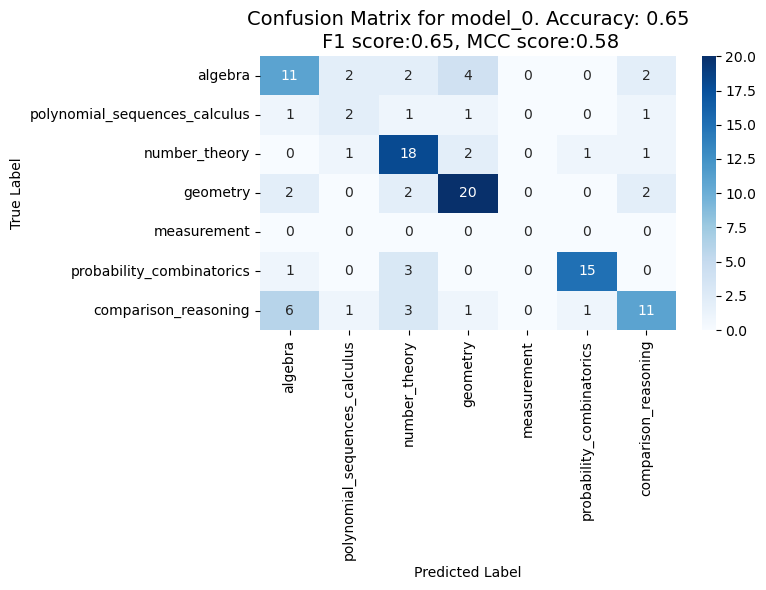

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_0'

data_tokenized = tokenizing_data(df_concept_duong['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df_concept_duong['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_duong_data_" + current_model + ".png")
plt.show()

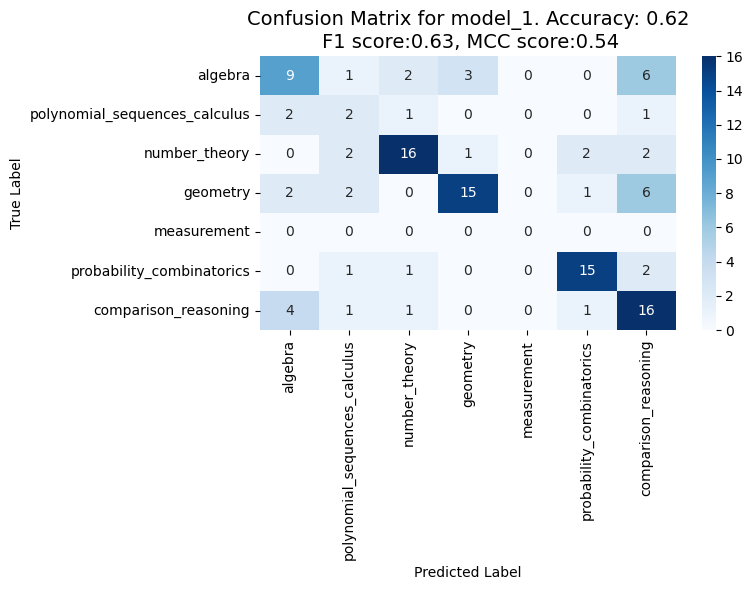

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_1'

data_tokenized = tokenizing_data(df_concept_duong['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df_concept_duong['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_duong_data_" + current_model + ".png")
plt.show()

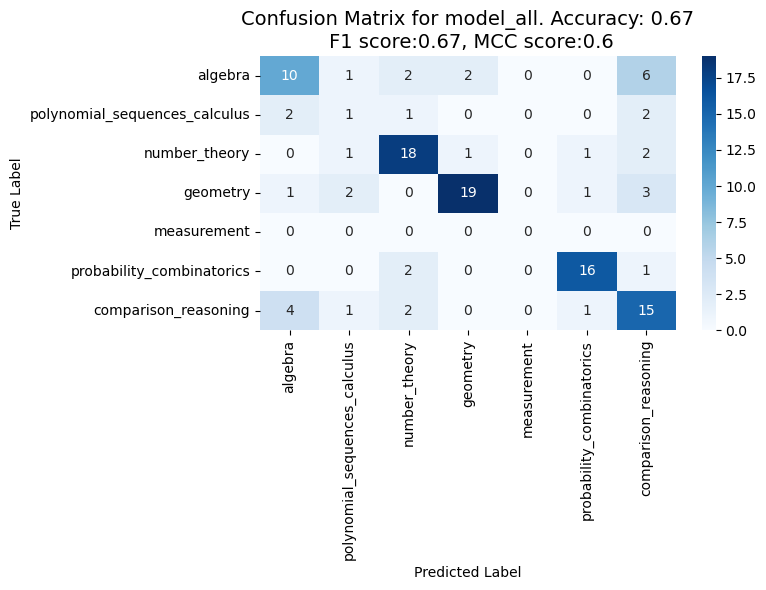

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_all'

data_tokenized = tokenizing_data(df_concept_duong['problem'],tokenizer)   #tokenizing
output_0 = model_predict(data_tokenized,model_dict['model_0'])         #predicting
output_1 = model_predict(data_tokenized,model_dict['model_1'])         #predicting
y_pred = np.argmax(output_0 + output_1,axis=1)
y_test = list(df_concept_duong['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_duong_data_" + current_model + ".png")
plt.show()

## concept_champ data

In [27]:
CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/Duong_data/'

In [28]:
champ_concept_mapping = {
    'Algebra': 0,
    'Polynomial': 1,
    'Sequence': 2,
    'Number-Theory': 3,
    'Combinatorics': 4,
    'Inequality': 5,
}

list_champ_topic_type = ['Algebra','Polynomial','Sequence','Number-Theory','Combinatorics','Inequality']


df_concept_champ = pd.read_csv(DATA_DIR + 'testset_champ_data.csv',index_col=0)
df_concept_champ['topic_encoded'] = df_concept_champ['topic'].map(champ_concept_mapping)

df_concept_champ

,topic,problem,topic_encoded
80,Number-Theory,"If d | a and d | b, then d | ax+by, d | a + b and d | a-b.",3
81,Algebra,a^n-1=(a-1)(a^(n-1)+a^(n-2)+...+a+1).,0
82,Polynomial,f(x)=0 is the only polynomial function with infinite number of zeros.,1
83,Inequality,"For any real number a, a^2≥0.",5
84,Algebra,x^2-y^2=(x+y)(x-y).,0
85,Polynomial,"A polynomial f(x) of degree n is reciprocal if the coefficients of x^i and x^(n-i) are the same for all i=0, 1, ..., n, and such a polynomial with an odd degree n always has a root of -1 and can be written as f(x)=(x+1)g(x).",1
86,Inequality,"For real numbers a_(1,1)≤...≤a_(1,n), a_(2,1)≤...≤a_(2,n), ..., a_(m,1)≤...≤a_(m,n), we have a_(1,1)*a_(2,1)*...*a_(m,1)+...+a_(1,n)*a_(2,n)*...*a_(m,n)≥a_(1,1)*b_(2,1)*...*b_(m,1)+...+a_(1,n)*b_(2,n)*...*b_(m,n), where (b_(i,1), ..., b_(i, n)) is a permutation of (a_(i,1), ..., a_(i, n)) for i=2, 3, ..., m. More generally, the sum achieves the maximum value when all the sequences (a_(i,1),..., a_(i,n)) are sorted in the same way.",5
87,Polynomial,A root with multiplicity k for a polynomial f(x) is a root with multiplicity k-1 for f'(x).,1
88,Number-Theory,A number is a multiple of 3 if and only if its digit sum is divisible by 3.,3


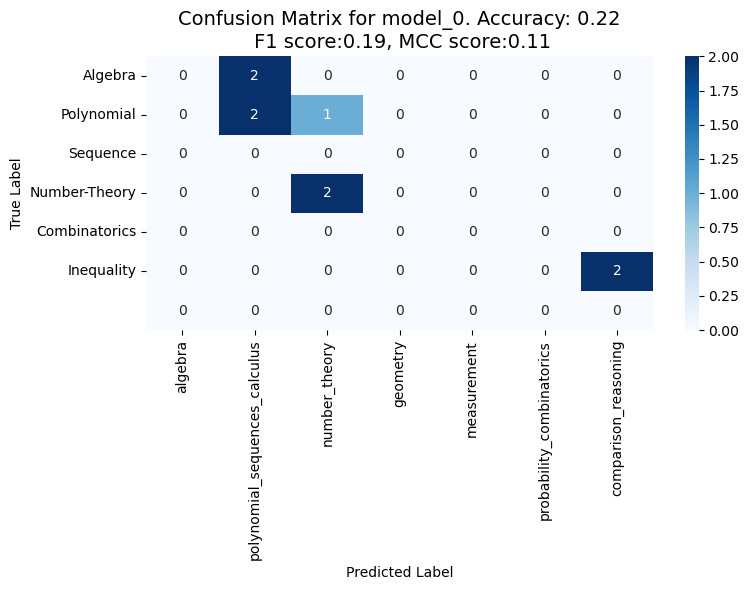

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_0'


data_tokenized = tokenizing_data(df_concept_champ['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df_concept_champ['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_champ_data_" + current_model +".png")
plt.show()

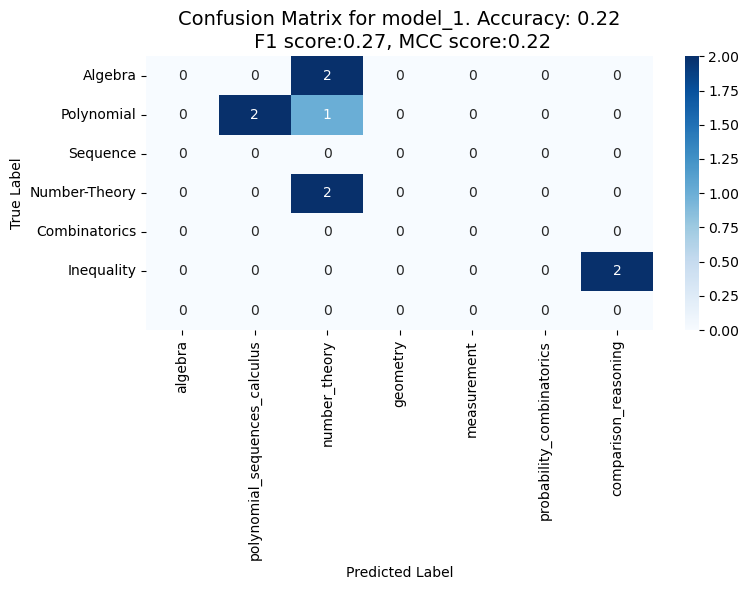

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_1'


data_tokenized = tokenizing_data(df_concept_champ['problem'],tokenizer)   #tokenizing
output = model_predict(data_tokenized,model_dict[current_model])         #predicting
y_pred = np.argmax(output,axis=1)
y_test = list(df_concept_champ['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_champ_data_" + current_model +".png")
plt.show()

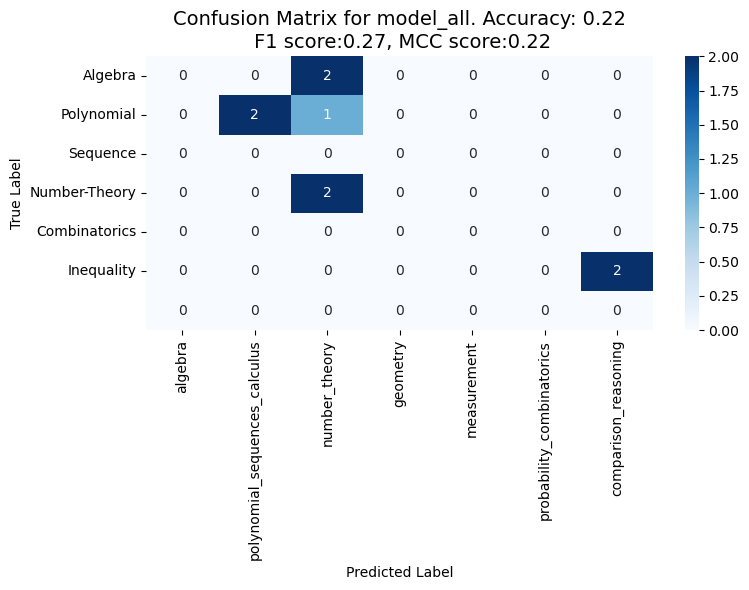

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

current_model = 'model_all'


data_tokenized = tokenizing_data(df_concept_champ['problem'],tokenizer)   #tokenizing
output_0 = model_predict(data_tokenized,model_dict['model_0'])         #predicting
output_1 = model_predict(data_tokenized,model_dict['model_1'])         #predicting

y_pred = np.argmax(output_0 + output_1,axis=1)
y_test = list(df_concept_champ['topic_encoded'])

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6])

#Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=list_champ_topic_type)

# Label axes
plt.title(f"Confusion Matrix for {current_model}. Accuracy: {round(accuracy,2)}\n F1 score:{round(f1,2)}, MCC score:{round(mcc,2)}", fontsize=14) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_concept_champ_data_" + current_model +".png")
plt.show()